<a href="https://colab.research.google.com/github/pshamoun/Assignment-1-Exploratory-Data-Analysis-EDA-and-Visualization/blob/main/1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import requests
import zipfile
import io
import pandas as pd

# URLs
kiva_loans_part_0_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_0.csv.zip'
kiva_loans_part_1_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_1.csv.zip'
kiva_loans_part_2_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_2.csv.zip'
mpi_region_locations_url = 'https://raw.githubusercontent.com/aaubs/ds-master/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv'
loan_theme_ids_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/loan_theme_ids.csv.zip'
loan_themes_by_region_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/loan_themes_by_region.csv'

# Function to download and extract CSV from a ZIP file
def load_csv_from_zip(url):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        for file_name in z.namelist():
            if not file_name.startswith('__MACOSX') and file_name.endswith('.csv'):
                with z.open(file_name) as f:
                    return pd.read_csv(f)

# Load the required CSV files
kiva_loans_part_0_df = load_csv_from_zip(kiva_loans_part_0_url)
kiva_loans_part_1_df = load_csv_from_zip(kiva_loans_part_1_url)
kiva_loans_part_2_df = load_csv_from_zip(kiva_loans_part_2_url)
mpi_region_locations_df = pd.read_csv(mpi_region_locations_url)
loan_theme_ids_df = load_csv_from_zip(loan_theme_ids_url)
loan_themes_by_region_df = pd.read_csv(loan_themes_by_region_url)

# Combine all Kiva loans data into one dataframe
kiva_loans_combined_df = pd.concat([kiva_loans_part_0_df, kiva_loans_part_1_df, kiva_loans_part_2_df], ignore_index=True)

# remove duplicate rows based on 'id'
kiva_loans_combined_df = kiva_loans_combined_df.drop_duplicates(subset='id')

merged_dataset = kiva_loans_combined_df.merge(loan_theme_ids_df, how='left', on='id')
merged_df = merged_dataset.merge(loan_themes_by_region_df, how='left', on=['Partner ID', 'Loan Theme ID', 'country', 'region'])

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector_x            671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

In [132]:
# Check for columns with NA value
na_counts = merged_df.isna().sum()

# Display only the columns where there are NA values
na_columns = na_counts[na_counts > 0]
print(na_columns)


use                     4232
country_code               8
region                 56800
partner_id             13507
disbursed_time          2396
funded_time            48331
tags                  171416
borrower_genders        4221
Loan Theme ID          13513
Loan Theme Type_x      13513
Partner ID             13513
Field Partner Name    137743
sector_y              137743
Loan Theme Type_y     137743
forkiva               137743
geocode_old           562228
ISO                   137744
number                137743
amount                137743
LocationName          137743
geocode               152217
names                 152218
geo                   137743
lat                   152217
lon                   152217
mpi_region            137744
mpi_geo               212152
rural_pct             170238
dtype: int64


In [137]:
#Drop unnecessary columns and drop rows where 'use' is missing
df_cleaned = merged_df.drop(columns=[
    'country_code', 'date', 'currency', 'partner_id', 'tags',
    'Loan Theme ID', 'Partner ID', 'forkiva', 'geocode_old', 'ISO',
    'LocationName', 'geocode', 'names', 'lat', 'lon', 'amount','number']).dropna(subset=['use'])

# Fill NA values in 'region', 'funded_time', 'disbursed_time', and 'rural_pct'
df_cleaned['region'].fillna('Unknown', inplace=True)
df_cleaned['funded_time'].fillna('Not provided', inplace=True)
df_cleaned['disbursed_time'].fillna('Not provided', inplace=True)
df_cleaned['rural_pct'] = df_cleaned['rural_pct'].astype(str).fillna('Unknown')

# Count male and female borrowers using a function
def count_gender(genders, gender_to_count):
    if pd.isna(genders):
        return 0
    return sum(gender.strip() == gender_to_count for gender in genders.split(', '))

# Apply the gender counting functions
df_cleaned['no_male_borrower'] = df_cleaned['borrower_genders'].apply(lambda x: count_gender(x, 'male'))
df_cleaned['no_female_borrower'] = df_cleaned['borrower_genders'].apply(lambda x: count_gender(x, 'female'))
df_cleaned['borrower_type'] = df_cleaned.apply(lambda row: 'single' if (row['no_male_borrower'] + row['no_female_borrower']) == 1 else 'group', axis=1)

# Drop the 'borrower_genders' column
df_cleaned.drop(columns=['borrower_genders'], inplace=True)

# Display the cleaned dataset
print(df_cleaned.head())



       id  funded_amount  loan_amount             activity        sector_x  \
0  653051          300.0        300.0  Fruits & Vegetables            Food   
1  653053          575.0        575.0             Rickshaw  Transportation   
2  653068          150.0        150.0       Transportation  Transportation   
3  653063          200.0        200.0           Embroidery            Arts   
4  653084          400.0        400.0           Milk Sales            Food   

                                                 use   country        region  \
0            To buy seasonal, fresh fruits to sell.   Pakistan        Lahore   
1  to repair and maintain the auto rickshaw used ...  Pakistan        Lahore   
2  To repair their old cycle-van and buy another ...     India     Maynaguri   
3  to purchase an embroidery machine and a variet...  Pakistan        Lahore   
4                           to purchase one buffalo.  Pakistan  Abdul Hakeem   

                 posted_time             disbursed

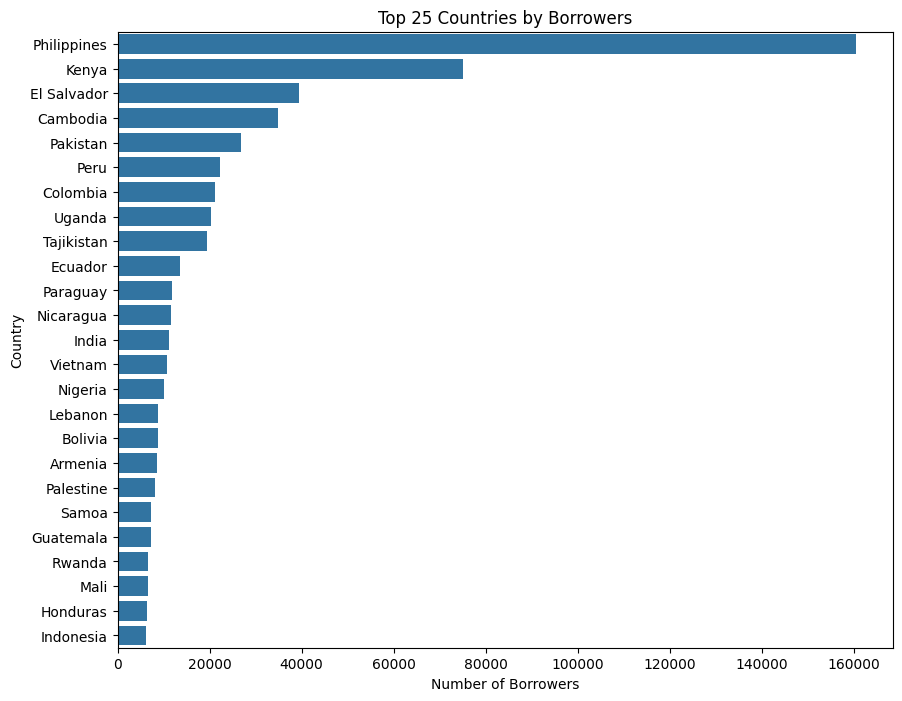

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns




# Group data by country and count loans
loan_count_countries = df_cleaned.groupby('country')['id'].count().reset_index().sort_values(by='id', ascending=False)
loan_count_countries.columns = ['country', 'count']

# Plot only the top 25 countries
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='country', data=loan_count_countries.head(25))
plt.xlabel('Number of Borrowers')
plt.ylabel('Country')
plt.title('Top 25 Countries by Borrowers')
plt.show()




The Philippines, Kenya, and Cambodia lead in terms of the total number of borrowers, indicating high demand for loans in these countries.
This high volume can be reflective of both the size of the population in need and the effectiveness of microfinance services in these countries.

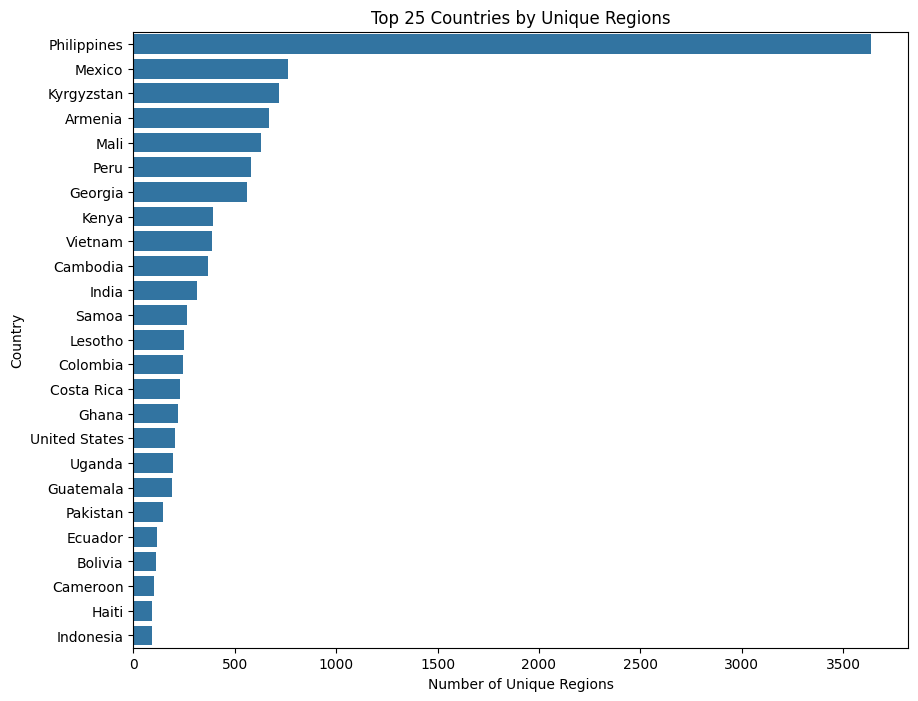

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and count unique regions
region_count = df_cleaned.groupby('country')['region'].nunique().reset_index().sort_values(by='region', ascending=False)
region_count.columns = ['country', 'unique_regions']

# Plot only the top 25 countries
plt.figure(figsize=(10, 8))
sns.barplot(x='unique_regions', y='country', data=region_count.head(25))
plt.xlabel('Number of Unique Regions')
plt.ylabel('Country')
plt.title('Top 25 Countries by Unique Regions')
plt.show()



The Philippines has the most unique regions receiving loans, showing a broad reach of microfinance across the country.

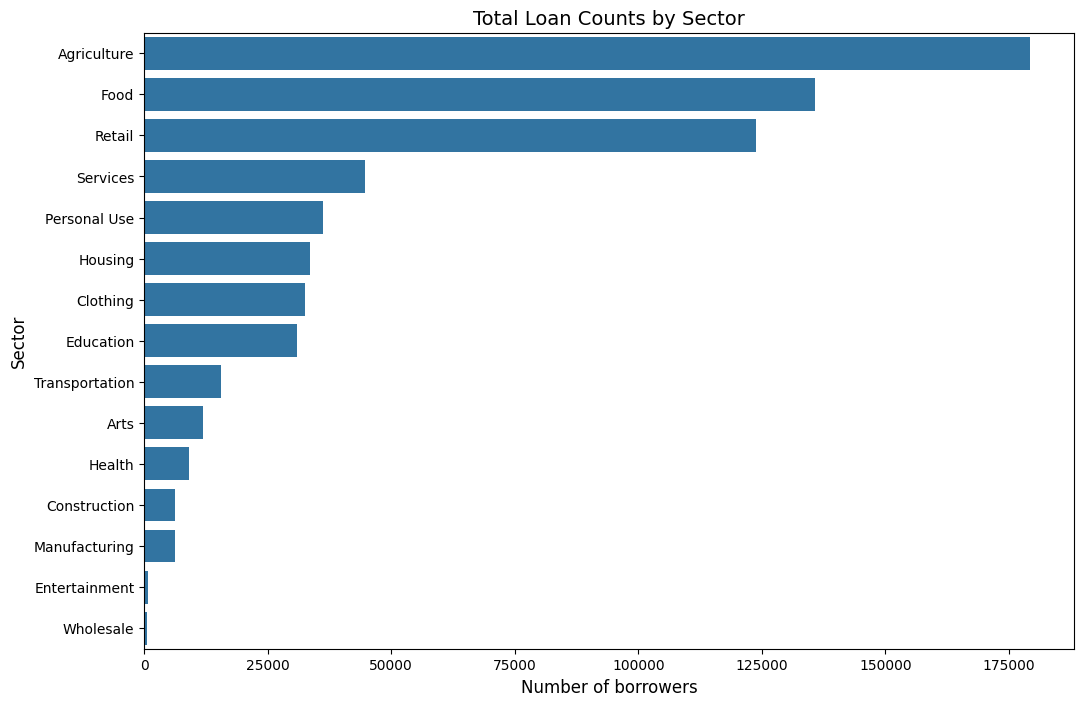

In [126]:
# Grouping the data by sector and calculating the count of loans for each sector
sector_loan_counts = df_cleaned.groupby('sector_x')['id'].count().reset_index().sort_values(by='id', ascending=False)
sector_loan_counts.columns = ['sector', 'loan_count']

# Plotting the distribution of loan counts by sector
plt.figure(figsize=(12, 8))
sns.barplot(x='loan_count', y='sector', data=sector_loan_counts)
plt.xlabel('Number of borrowers', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.title('Total Loan Counts by Sector', fontsize=14)
plt.show()


Agriculture and Food are the sectors with the highest number of loans, which may indicate the primary economic activities in the regions studied.

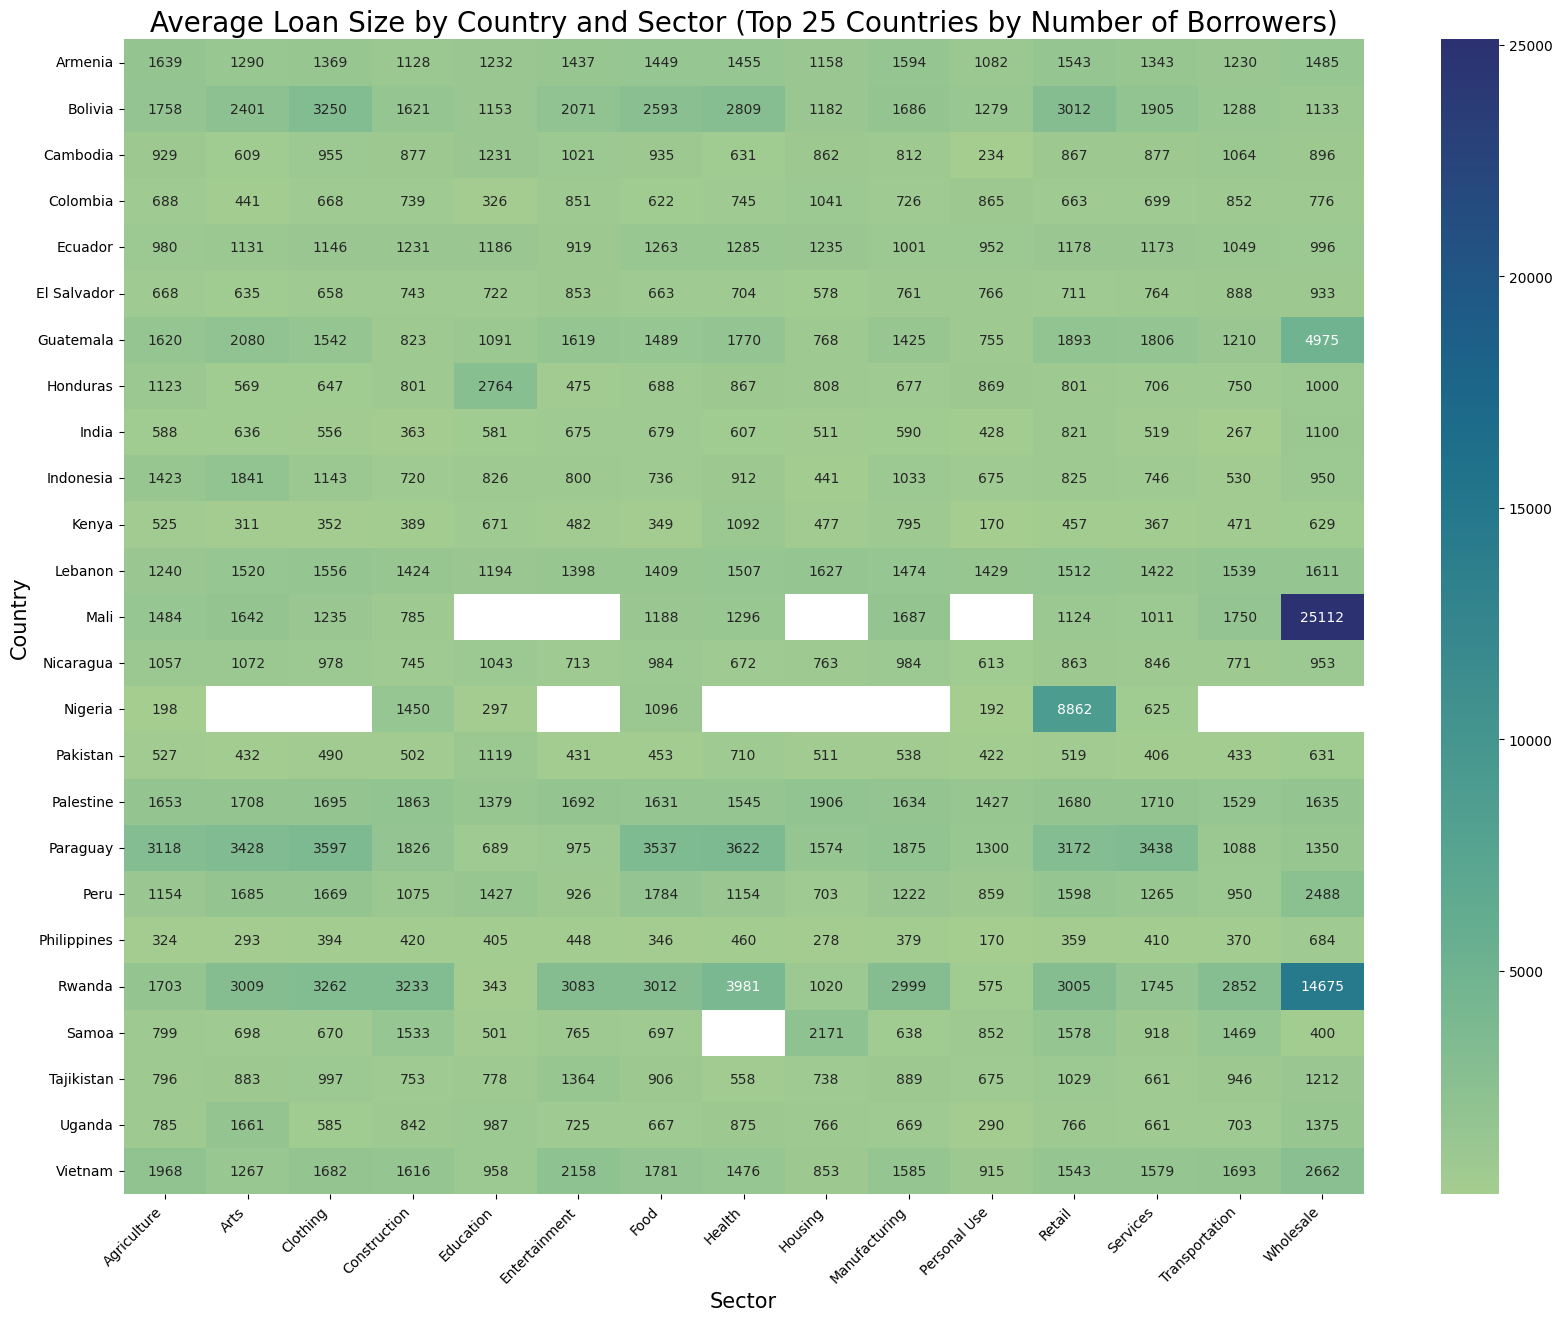

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt


# Filter the main dataset to include only the top 25 countries
top_25_countries = loan_count_countries['country'].head(25)
filtered_data = df_cleaned[df_cleaned['country'].isin(top_25_countries)]

# Calculate average loan size by country and sector for the filtered data
avg_loan_size_filtered = filtered_data.groupby(['country', 'sector_x'])['loan_amount'].mean().reset_index()

# pivot table for the heatmap
heatmap_data_filtered = avg_loan_size_filtered.pivot_table(index='country', columns='sector_x', values='loan_amount')

# Plotting the heatmap
plt.figure(figsize=(20, 15))
ax = sns.heatmap(heatmap_data_filtered, annot=True, fmt=".0f", cmap="crest", annot_kws={"size": 10})
plt.title('Average Loan Size by Country and Sector (Top 25 Countries by Number of Borrowers)', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Sector', fontsize=15)
plt.ylabel('Country', fontsize=15)
plt.show()



There is considerable variation in average loan sizes across different sectors and countries, suggesting differential capital needs and varying levels of economic development. Countries with smaller average loan sizes may be focusing on micro-loans accessible to a broader segment of the population.


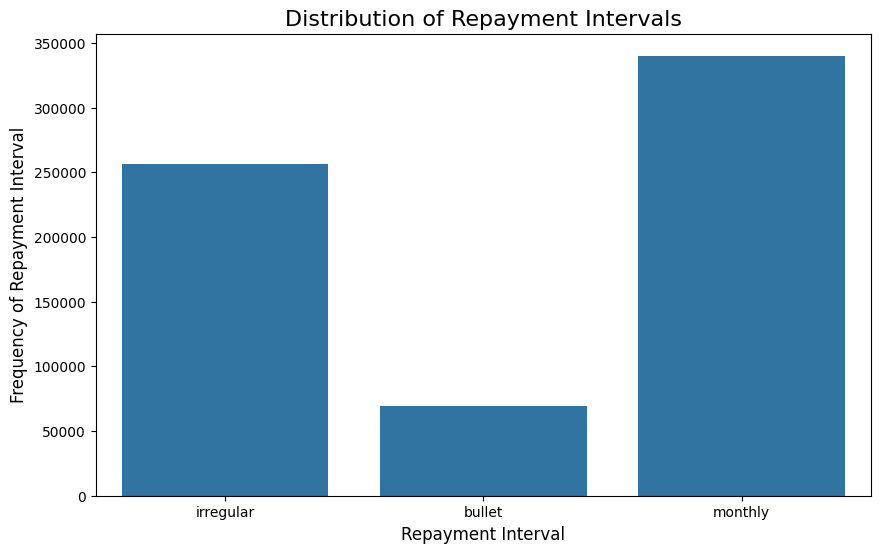

In [145]:
# Filter out 'weekly'
df_cleaned = df_cleaned[df_cleaned['repayment_interval'] != 'weekly']

# Now plot again
plt.figure(figsize=(10, 6))
sns.countplot(x='repayment_interval', data=df_cleaned)
plt.title('Distribution of Repayment Intervals', fontsize=16)
plt.xlabel('Repayment Interval', fontsize=12)
plt.ylabel('Frequency of Repayment Interval', fontsize=12)
plt.show()


The repayment intervals across sectors and countries reveal a few distinct patterns. Sectors such as agriculture, food, retail, education, personal use and services have the highest concentration of loans, and these sectors tend to favor monthly repayment intervals. The irregular repayment schedule is prominent in food and retail sectors. Bullet repayments are mostly concentrated in agriculture but are also seen across multiple sectors in smaller amounts.

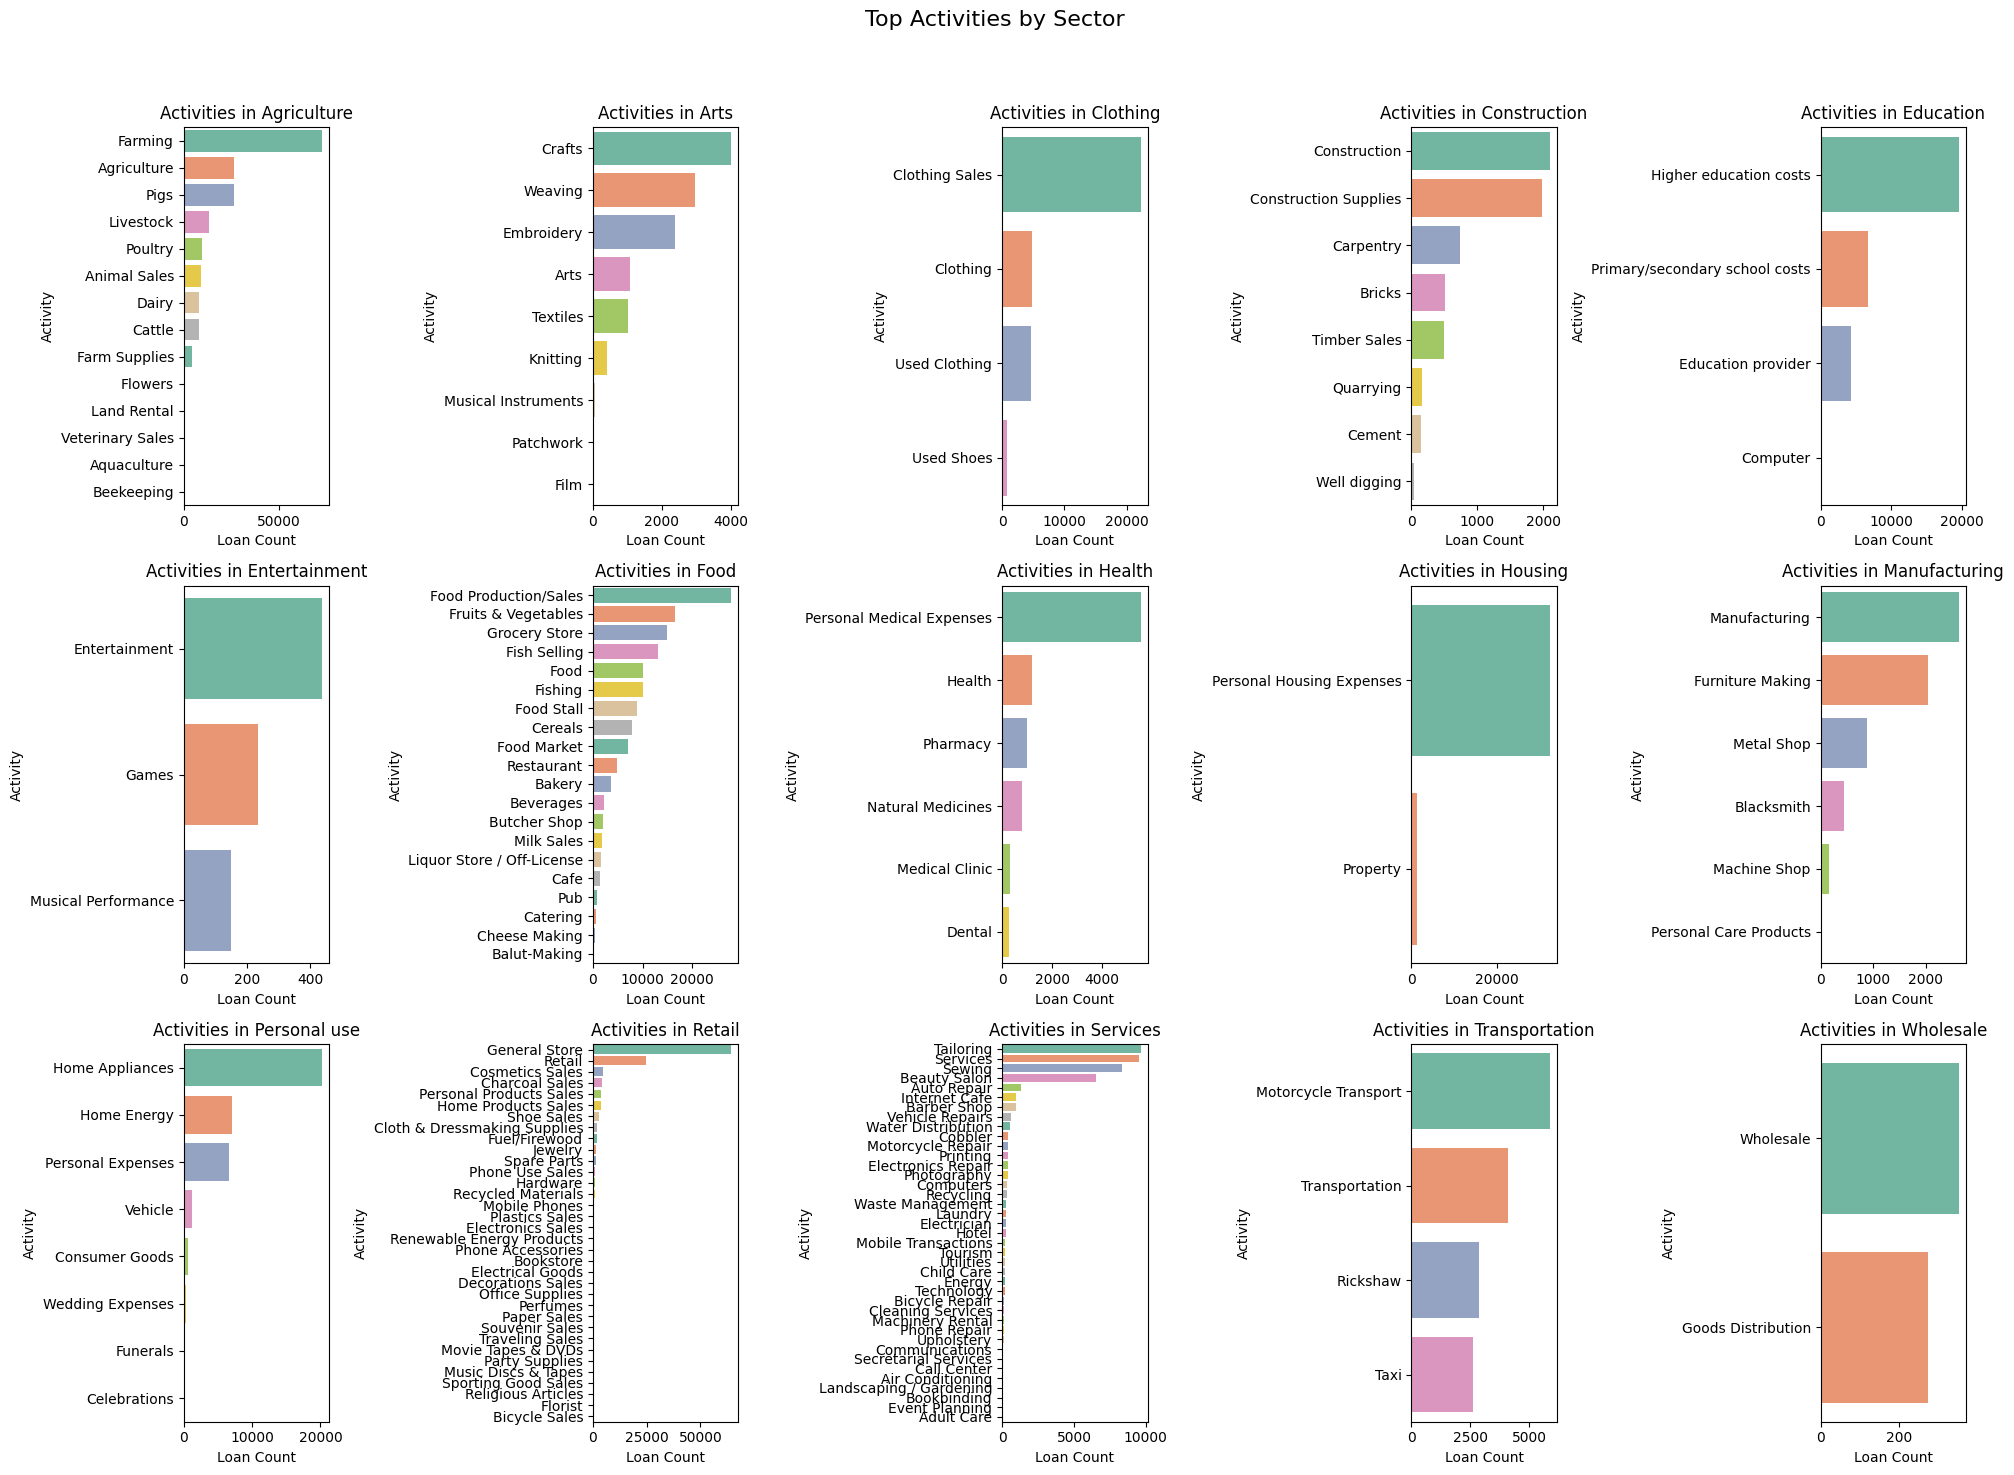

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by sector and activity, and count the number of loans for each
activity_counts_by_sector = df_cleaned.groupby(['sector_x', 'activity'])['id'].count().reset_index()
activity_counts_by_sector.columns = ['Sector', 'Activity', 'Loan_Count']

# Get unique sectors to create subplots for each sector
unique_sectors = activity_counts_by_sector['Sector'].unique()

# Set up the grid for 15 plots
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
fig.suptitle('Top Activities by Sector', fontsize=16)

# Plot each sector in the grid
for i, sector in enumerate(unique_sectors):
    # Select data for the current sector
    sector_data = activity_counts_by_sector[activity_counts_by_sector['Sector'] == sector]

    # Sort by the count of loans
    sector_data = sector_data.sort_values(by='Loan_Count', ascending=False)

    # Get the axis for the subplot
    ax = axes[i // 5, i % 5]

    # Plot the barplot with hue
    sns.barplot(x='Loan_Count', y='Activity', data=sector_data, ax=ax, hue='Activity', palette='Set2', dodge=False, legend=False)

    ax.set_title(f'Activities in {sector.capitalize()}')
    ax.set_xlabel('Loan Count')
    ax.set_ylabel('Activity')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



 In agriculture, farming is by far the most prominent activity, followed by pig and general agriculture-related activities. In contrast, sectors like construction and clothing show more diversified activities but with smaller loan counts compared to agriculture.

 Retail stands out with general stores receiving the largest number of loans, showcasing its central role in many communities. The food sector has a wide array of activities, including fish selling, food production, and grocery store-related work, reflecting the importance of food-related businesses in loan applications.

 In personal use, home appliances dominate, indicating the prevalence of household-related expenses. Similarly, sectors like health, entertainment, and manufacturing have fewer activities, suggesting more specialized needs and fewer borrowers compared to agriculture or retail.

 Overall, these patterns indicate that agriculture, retail, and food dominate loan activity, while sectors like arts, entertainment, and transportation are smaller in scope but still vital for certain communities.

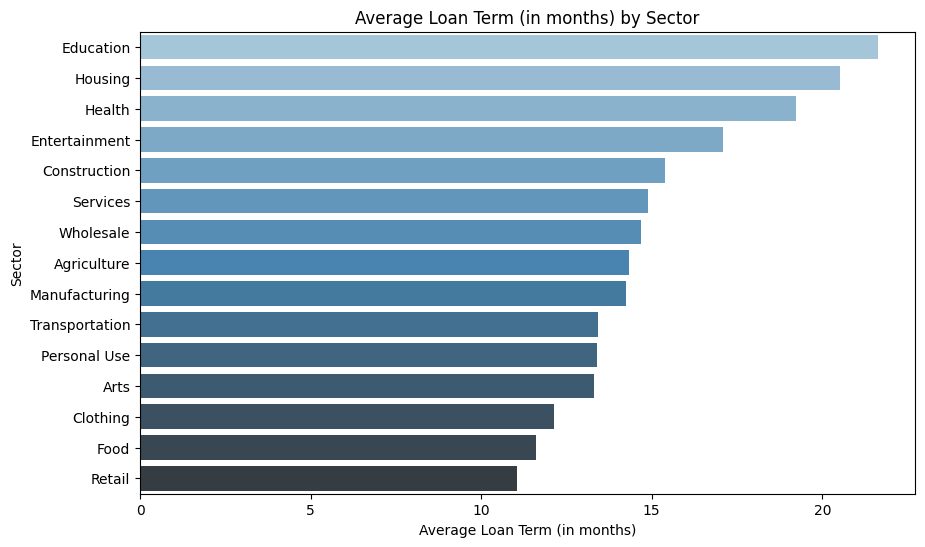

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by sector to calculate the average loan term and sort by term_in_months
avg_loan_term_sector = df_cleaned.groupby('sector_x')['term_in_months'].mean().reset_index()
avg_loan_term_sector = avg_loan_term_sector.sort_values(by='term_in_months', ascending=False)

# Plotting the bar chart for Loan Term by Sector
plt.figure(figsize=(10, 6))
sns.barplot(x='term_in_months', y='sector_x', data=avg_loan_term_sector, hue='sector_x', palette="Blues_d", dodge=False, legend=False)

plt.title('Average Loan Term (in months) by Sector')
plt.xlabel('Average Loan Term (in months)')
plt.ylabel('Sector')

plt.show()




The bar chart shows that the sectors with the longest average loan terms are education, housing, and health, each with an average loan term exceeding 15 months. These sectors likely require longer loan durations due to the nature of investments in education and housing, which tend to involve larger amounts and longer repayment periods. On the other hand, sectors like retail and food have significantly shorter loan terms, indicating a quicker turnover of loans in those industries, possibly reflecting the need for short-term capital in day-to-day business operations.